In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display
from transformers import BertTokenizer, TFBertModel

C:\Users\HMILAB\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.keras.layers import Input, Embedding, LSTM, \
Conv2D, Conv2DTranspose, Dense, Flatten, BatchNormalization
from tensorflow.python.keras import Sequential

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# dictionary_path = './dictionary'
# vocab = np.load(dictionary_path + '/vocab.npy')
# print('there are {} vocabularies in total'.format(len(vocab)))

# word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
# id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
# print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
# print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
# print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

In [7]:
# def sent2IdList(line, MAX_SEQ_LENGTH=20):
#     MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
#     padding = 0
    
#     # data preprocessing, remove all puntuation in the texts
#     prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
#     prep_line = prep_line.replace('-', ' ')
#     prep_line = prep_line.replace('-', ' ')
#     prep_line = prep_line.replace('  ', ' ')
#     prep_line = prep_line.replace('.', '')
#     tokens = prep_line.split(' ')
#     tokens = [
#         tokens[i] for i in range(len(tokens))
#         if tokens[i] != ' ' and tokens[i] != ''
#     ]
#     l = len(tokens)
#     padding = MAX_SEQ_LIMIT - l
    
#     # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
#     for i in range(padding):
#         tokens.append('<PAD>')
#     line = [
#         word2Id_dict[tokens[k]]
#         if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
#         for k in range(len(tokens))
#     ]

#     return line

# text = "the flower shown has yellow anther red pistil and bright red petals."
# print(text)
# print(sent2IdList(text))

In [8]:
# data_path = '../data/'
# df = pd.read_pickle(data_path + '/text2ImgData.pkl')
# num_training_sample = len(df)
# n_images_train = num_training_sample
# print('There are %d image in training data' % (n_images_train))

In [9]:
# df.head(5)

In [10]:
BATCH_SIZE = 64
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': BATCH_SIZE,
    'LR': 0.0002,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 10000,
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 5                          # printing frequency of loss
}

In [11]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
#     img = tf.image.random_flip_left_right(img)
#     img = tf.image.random_flip_up_down(img)
    
#     if(random.random() < 0.5):
#         img = tf.image.stateless_random_crop(img, (48, 48, 3), seed = (0,1))
#         img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
#     caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    image_path=[]
    image_class=[]
    with open(filenames) as f:
        lines = f.readlines()
        for line in lines:
            image_path.append("../data/fgvc-aircraft-2013b/data/images/"+line.split(" ")[0]+".jpg")
            image_class.append(line.split(" ")[1].split("\n")[0])
    captions = image_class
    caption = np.asarray(captions)
    image_path = np.asarray(image_path)
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((captions, image_path))
    dataset = dataset.map(training_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(captions)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    

    return dataset

In [12]:
dataset = dataset_generator("../data/fgvc-aircraft-2013b/data/images_manufacturer_trainval.txt", hparas["BATCH_SIZE"], training_data_generator)

In [13]:
image, caption = next(iter(dataset))

In [14]:
print(caption.shape)
print(len(dataset))

(64,)
104


tf.Tensor(b'Canadair', shape=(), dtype=string)


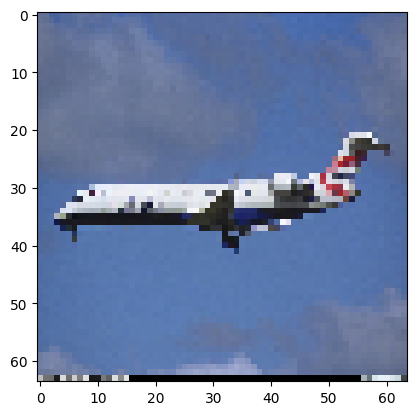

In [15]:
for i in range(image.shape[0]):
    print(caption[i])
    plt.imshow(image[i])
    plt.show()
    break

# Text Encoder

In [16]:
def id2sentence(id2word_dict, id_sent):
    batch_sentence = []
    for j in range(id_sent.shape[0]):
        sent=""
        for i in range(len(id_sent[j])):
            if id2word_dict[str(id_sent[j][i].numpy())]=="<PAD>":
                continue
            sent=sent+" "+(id2word_dict[str(id_sent[j][i].numpy())])
        
        batch_sentence.append(sent)
    return batch_sentence

In [17]:
bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased', 
    do_lower_case=False,
    do_basic_tokenize=False
)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
def convert_to_str(caption):
    str_list = []
    for i in range(len(caption)):
        
        str_list.append(str(caption[i].numpy()))
    return str_list

In [19]:
def text_encoder(caption):
    string_list = convert_to_str(caption)
    bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
    bert_outputs = bert_model(bert_inputs)
    caption_embedding = bert_outputs.last_hidden_state[:,0]
    return tf.convert_to_tensor(caption_embedding.numpy().tolist())

In [20]:
text_embed = text_encoder(caption)


# Generator

In [21]:
NUM_EPOCHS = 10000
LEAKY_ALPHA = 0.2
def my_leaky_relu(tensor):
    return tf.nn.leaky_relu(tensor, alpha=LEAKY_ALPHA)

In [22]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = Flatten()
#         self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.d2 = tf.keras.layers.Dense(64*64*3)

        self.d1 = Dense(self.hparas['DENSE_DIM'], activation=my_leaky_relu)
        self.d2 = Dense(128*8*4*4)
        self.BN0 = BatchNormalization()
        
        self.conv1 = Conv2D(
            filters=256,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN1 = BatchNormalization()
        
        self.conv2 = Conv2D(
            filters=256,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN2 = BatchNormalization()
        
        self.conv3 = Conv2D(
            filters=128*8,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        
        self.BN3 = BatchNormalization()
        
        self.conv4_T = Conv2DTranspose(
            filters=128*4,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same"
        )
        self.BN4 = BatchNormalization()
        
        self.conv5 = Conv2D(
            filters=128,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN5 = BatchNormalization()
        
        self.conv6 = Conv2D(
            filters=128,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN6 = BatchNormalization()
        
        
        self.conv7 = Conv2D(
            filters=128*4,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        self.BN7 = BatchNormalization()
        
        self.conv8_T = Conv2DTranspose(
            filters=128*2,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN8 = BatchNormalization()
        
        self.conv9_T = Conv2DTranspose(
            filters=128,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN9 = BatchNormalization()
    
        self.out = Conv2DTranspose(
            filters=3,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
#             activation=tf.tanh
        )
        
        
    def call(self, text, noise_z):

        text = self.flatten(text)
        x0 = self.d1(text)
        x0 = tf.concat([noise_z, x0], axis=1)
        x0 = self.d2(x0)
        x0 = self.BN0(x0)
        x0 = tf.reshape(x0, shape=[-1, 4, 4, 128*8])
        
        x1 = self.conv1(x0)
        x1 = self.BN1(x1)
        x1 = self.conv2(x1)
        x1 = self.BN2(x1)
        x1 = self.conv3(x1)
        x1 = self.BN3(x1)
        
        x2 = tf.add(x0, x1)
        x2 = self.conv4_T(x2)
        x2 = self.BN4(x2)
        x = self.conv5(x2)
        x = self.BN5(x)
        x = self.conv6(x)
        x = self.BN6(x)
        x = self.conv7(x)
        x = self.BN7(x)
        
        x3 = tf.add(x2, x)
        x3 = self.conv8_T(x3)
        x3 = self.BN8(x3)
        x3 = self.conv9_T(x3)
        x3 = self.BN9(x3)
        
        logits = self.out(x3)
        output = tf.nn.tanh(logits)


        return logits, output

# Discriminator

In [23]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = Flatten()

        
        self.conv1 = Conv2D(
            filters=64,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.conv2 = Conv2D(
            filters=128,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.BN2 = BatchNormalization()
        
        self.conv3 = Conv2D(
            filters=256,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.BN3 = BatchNormalization()
        
        self.conv4 = Conv2D(
            filters=512,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=None
        )
        self.BN4 = BatchNormalization()
        
        self.conv5 = Conv2D(
            filters=128,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN5 = BatchNormalization()
        
        self.conv6 = Conv2D(
            filters=128,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN6 = BatchNormalization()
        
        self.conv7 = Conv2D(
            filters=512,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        self.BN7 = BatchNormalization()
        
        
        
        #text
        
        self.d1 = Dense(self.hparas['DENSE_DIM'], activation=my_leaky_relu)
        
        self.conv8 = Conv2D(
            filters=512,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN8 = BatchNormalization()
        
        self.out = Conv2D(
            filters=1,
            kernel_size=[4, 4],
            strides=[4, 4],
            padding="valid"
        )
    
    def call(self, img, text):
        
        x0 = self.conv1(img)
        x0 = self.conv2(x0)
        x0 = self.BN2(x0)
        x0 = self.conv3(x0)
        x0 = self.BN3(x0)
        x0 = self.conv4(x0)
        x0 = self.BN4(x0)
        
        x = self.conv5(x0)
        x = self.BN5(x)
        x = self.conv6(x)
        x = self.BN6(x)
        x = self.conv7(x)
        x = self.BN7(x)
        
        x1 = tf.add(x0, x)
        
        #text
        x2 = self.d1(text)
        x2 = tf.expand_dims(x2, axis=1)
        x2 = tf.expand_dims(x2, axis=1)
        
        x2 = tf.tile(x2, multiples=[1, 4, 4, 1])
        x3 = tf.concat(values=[x1, x2], axis=3)
        x3 = self.conv8(x3)
        x3 = self.BN8(x3)
        
        logits = self.out(x3)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [24]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [25]:
image, caption  = next(iter(dataset))
text_embed = text_encoder(caption)   
noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
_, fake_image = generator(text_embed, noise)
fake_logits, fake_output = discriminator(fake_image, text_embed)  

In [26]:
# generator.load_weights("models/W_generator_bert_epoch1300.h5")
# discriminator.load_weights("models/W_discriminator_bert_epoch1300.h5")

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_logits, fake_logits, mismatch_logits):

    real_loss = tf.reduce_mean(cross_entropy(tf.ones_like(real_logits), real_logits))

    fake_loss = tf.reduce_mean(cross_entropy(tf.zeros_like(fake_logits), fake_logits))
    
    dismatch_loss = tf.reduce_mean(cross_entropy(tf.zeros_like(mismatch_logits), mismatch_logits))
    
    total_loss = real_loss + fake_loss + dismatch_loss

    
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return tf.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))

In [28]:
optimizer_g = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1=hparas['BETA_1'])
optimizer_d = tf.keras.optimizers.Adam(learning_rate = 3e-4, beta_1=hparas['BETA_1'])

In [29]:
checkpoint_dir = "checkpoint_dir"
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,
                                 discriminator_optimizer=optimizer_d,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_dir, max_to_keep=3)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
LAMBDA = 10

@tf.function
def WGTrain(real_image, caption, noise_decay):
    #c1: true image
#     z = tf.random.normal(BZ)
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as tpg, tf.GradientTape() as inter_tpg:
        text_embed = text_encoder(caption)
        
        #c0: fake image
        _, fake_image = generator(text_embed, noise)
        alpha = tf.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1])
        interpolates = alpha * fake_image + (1.0 - alpha) * real_image
        
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)
        mismatch_logits, mismatch_output = discriminator(interpolates, text_embed)

        gradient_penalty = inter_tpg.gradient(mismatch_logits,interpolates)
        gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
        loss = fake_logits - real_logits + 10. * tf.math.square((gradient_penalty - 1.))
        ld = tf.reduce_mean(loss)
        lg = - tf.reduce_mean(fake_logits)

    gradient_g = tpg.gradient(lg, generator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, generator.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(real_image, caption, noise_decay):
    #c1: true image
#     z = tf.random.normal(BZ)
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tpd, tf.GradientTape() as inter_tpg:
        text_embed = text_encoder(caption)
        
        
        #c0: fake image
        _, fake_image = generator(text_embed, noise)
        alpha = tf.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1])
        interpolates = alpha * fake_image + (1.0 - alpha) * real_image
        
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)
        mismatch_logits, mismatch_output = discriminator(interpolates, text_embed)

        gradient_penalty = inter_tpg.gradient(mismatch_logits,interpolates)
        gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
        loss = fake_logits - real_logits + 10. * tf.math.square((gradient_penalty - 1.))
        ld = tf.reduce_mean(loss)
        lg = - tf.reduce_mean(fake_logits)


    gradient_d = tpd.gradient(ld, discriminator.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, discriminator.trainable_variables))
   
    return lg, ld

In [32]:
@tf.function
def test_step(caption, noise):
    text_embed = text_encoder(caption)
    _, fake_image = generator(text_embed, noise)
    return fake_image

In [33]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [34]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [35]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["Boeing"] * int(sample_size/ni) + \
                  ["Airbus"] * int(sample_size/ni) + \
                  ["ATR"] * int(sample_size/ni) + \
                  ["Antonov"] * int(sample_size/ni) + \
                  ["British"] * int(sample_size/ni) + \
                  ["Beechcraft"] * int(sample_size/ni) + \
                  ["Lockheed"] * int(sample_size/ni) +\
                  ["Douglas"] * int(sample_size/ni)


sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

In [36]:
print(len(sample_sentence))
print(len(dataset))

1
104


In [37]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

In [40]:
epoch_g_loss=[]
epoch_d_loss=[]
def train(dataset, epochs):
    # hidden state of RNN
    steps_per_epoch = len(dataset)
    ctr = 0
    for epoch in range(hparas['N_EPOCH']):
        print("Epoch : ", epoch+1)
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
#         if epoch < 200:
#             noise_decay = 1.0 / float(epoch+1)
#         else:
        noise_decay = 0.0
        
        for step, (image, caption) in enumerate(dataset):
            if step%30==0:
                print(step)
            g_loss, d_loss = WTrain[ctr](image, caption, noise_decay)
            ctr += 1
            g_total_loss += g_loss
            d_total_loss += d_loss
            if ctr == WCritic : 
                ctr = 0
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
        epoch_g_loss.append(g_total_loss/steps_per_epoch)
        epoch_d_loss.append(d_total_loss/steps_per_epoch)
        print("gen_loss: {:.4f}, disc_loss: {:.4f}".format(g_total_loss/steps_per_epoch,d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        if epoch % 15 == 0:
            manager.save(checkpoint_number=epoch)
        
        
#         visualization
#         if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
        for caption in sample_sentence:
            fake_image = test_step(caption, sample_seed)
        save_images(fake_image, [ni, ni], 'samples/bert_demo/train_{:05d}.jpg'.format(epoch))

In [41]:
# os.mkdir("samples/bert_demo")

In [ ]:
train(dataset, hparas['N_EPOCH'])

Epoch :  1
0
30
60
90
gen_loss: 18.1610, disc_loss: -8.3999
Time for epoch 1 is 20.3674 sec
Epoch :  2
0
30
60
90
gen_loss: 17.6948, disc_loss: -8.3604
Time for epoch 2 is 19.1836 sec
Epoch :  3
0
30
60
90
gen_loss: 17.7206, disc_loss: -8.3799
Time for epoch 3 is 17.7104 sec
Epoch :  4
0
30
60
90
gen_loss: 16.5859, disc_loss: -8.3627
Time for epoch 4 is 17.8773 sec
Epoch :  5
0
30
60
90
gen_loss: 17.4543, disc_loss: -8.3866
Time for epoch 5 is 17.8202 sec
Epoch :  6
0
30
60
90
gen_loss: 16.9446, disc_loss: -8.3815
Time for epoch 6 is 17.7681 sec
Epoch :  7
0
30
60
90
gen_loss: 16.8210, disc_loss: -8.3697
Time for epoch 7 is 17.7307 sec
Epoch :  8
0
30
60
90
gen_loss: 17.2166, disc_loss: -8.3998
Time for epoch 8 is 17.8183 sec
Epoch :  9
0
30
60
90
gen_loss: 16.6209, disc_loss: -8.3319
Time for epoch 9 is 17.7592 sec
Epoch :  10
0
30
60
90
gen_loss: 16.4340, disc_loss: -8.3624
Time for epoch 10 is 18.1920 sec
Epoch :  11
0
30
60
90
gen_loss: 17.1439, disc_loss: -8.3426
Time for epoch 11

30
60
90
gen_loss: 52.0914, disc_loss: -8.3960
Time for epoch 89 is 18.8937 sec
Epoch :  90
0
30
60
90
gen_loss: 36.9282, disc_loss: -8.4307
Time for epoch 90 is 19.0455 sec
Epoch :  91
0
30
60
90
gen_loss: 30.7783, disc_loss: -8.4098
Time for epoch 91 is 18.8767 sec
Epoch :  92
0
30
60
90
gen_loss: 28.1944, disc_loss: -8.4139
Time for epoch 92 is 19.0686 sec
Epoch :  93
0
30
60
90
gen_loss: 26.5222, disc_loss: -8.3758
Time for epoch 93 is 19.1581 sec
Epoch :  94
0
30
60
90
gen_loss: 25.5073, disc_loss: -8.3855
Time for epoch 94 is 19.4052 sec
Epoch :  95
0
30
60
90
gen_loss: 24.8066, disc_loss: -8.3797
Time for epoch 95 is 19.0868 sec
Epoch :  96
0
30
60
90
gen_loss: 22.8714, disc_loss: -8.4286
Time for epoch 96 is 19.2699 sec
Epoch :  97
0
30
60
90
gen_loss: 21.8440, disc_loss: -8.4070
Time for epoch 97 is 19.2769 sec
Epoch :  98
0
30
60
90
gen_loss: 21.3879, disc_loss: -8.4204
Time for epoch 98 is 19.2482 sec
Epoch :  99
0
30
60
90
gen_loss: 20.4877, disc_loss: -8.4276
Time for epoc